# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','리그','골/90','도움/90','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
midfielder_df = midfielder_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
midfielder_df.isna().sum()

이름              0
포지션             0
리그              0
골/90            0
도움/90           0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
승               0
무               0
패               0
시즌              0
구단              0
dtype: int64

## 변수 별 분포 확인

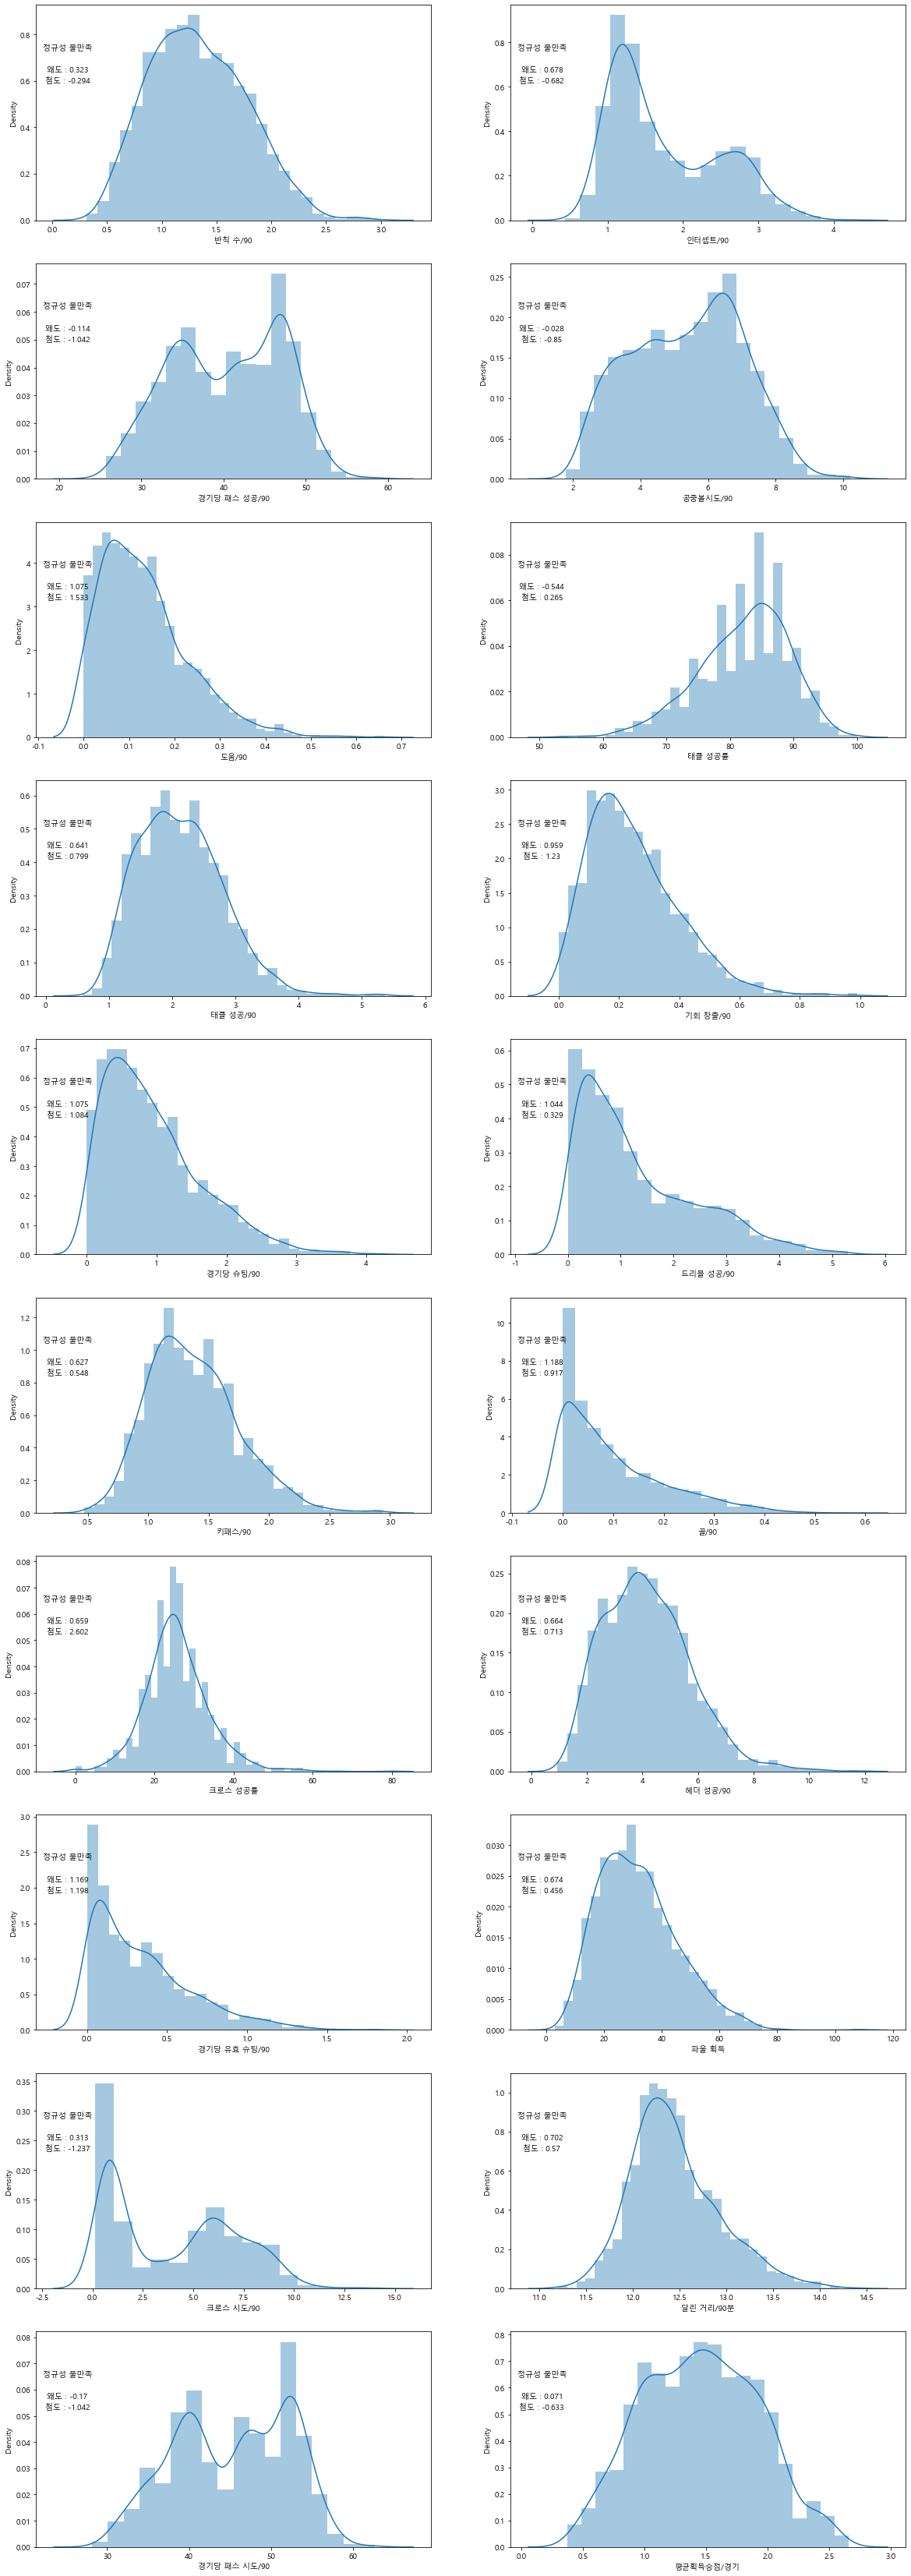

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = midfielder_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = midfielder_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

## 선형성 검정

모든 변수 선형성 만족

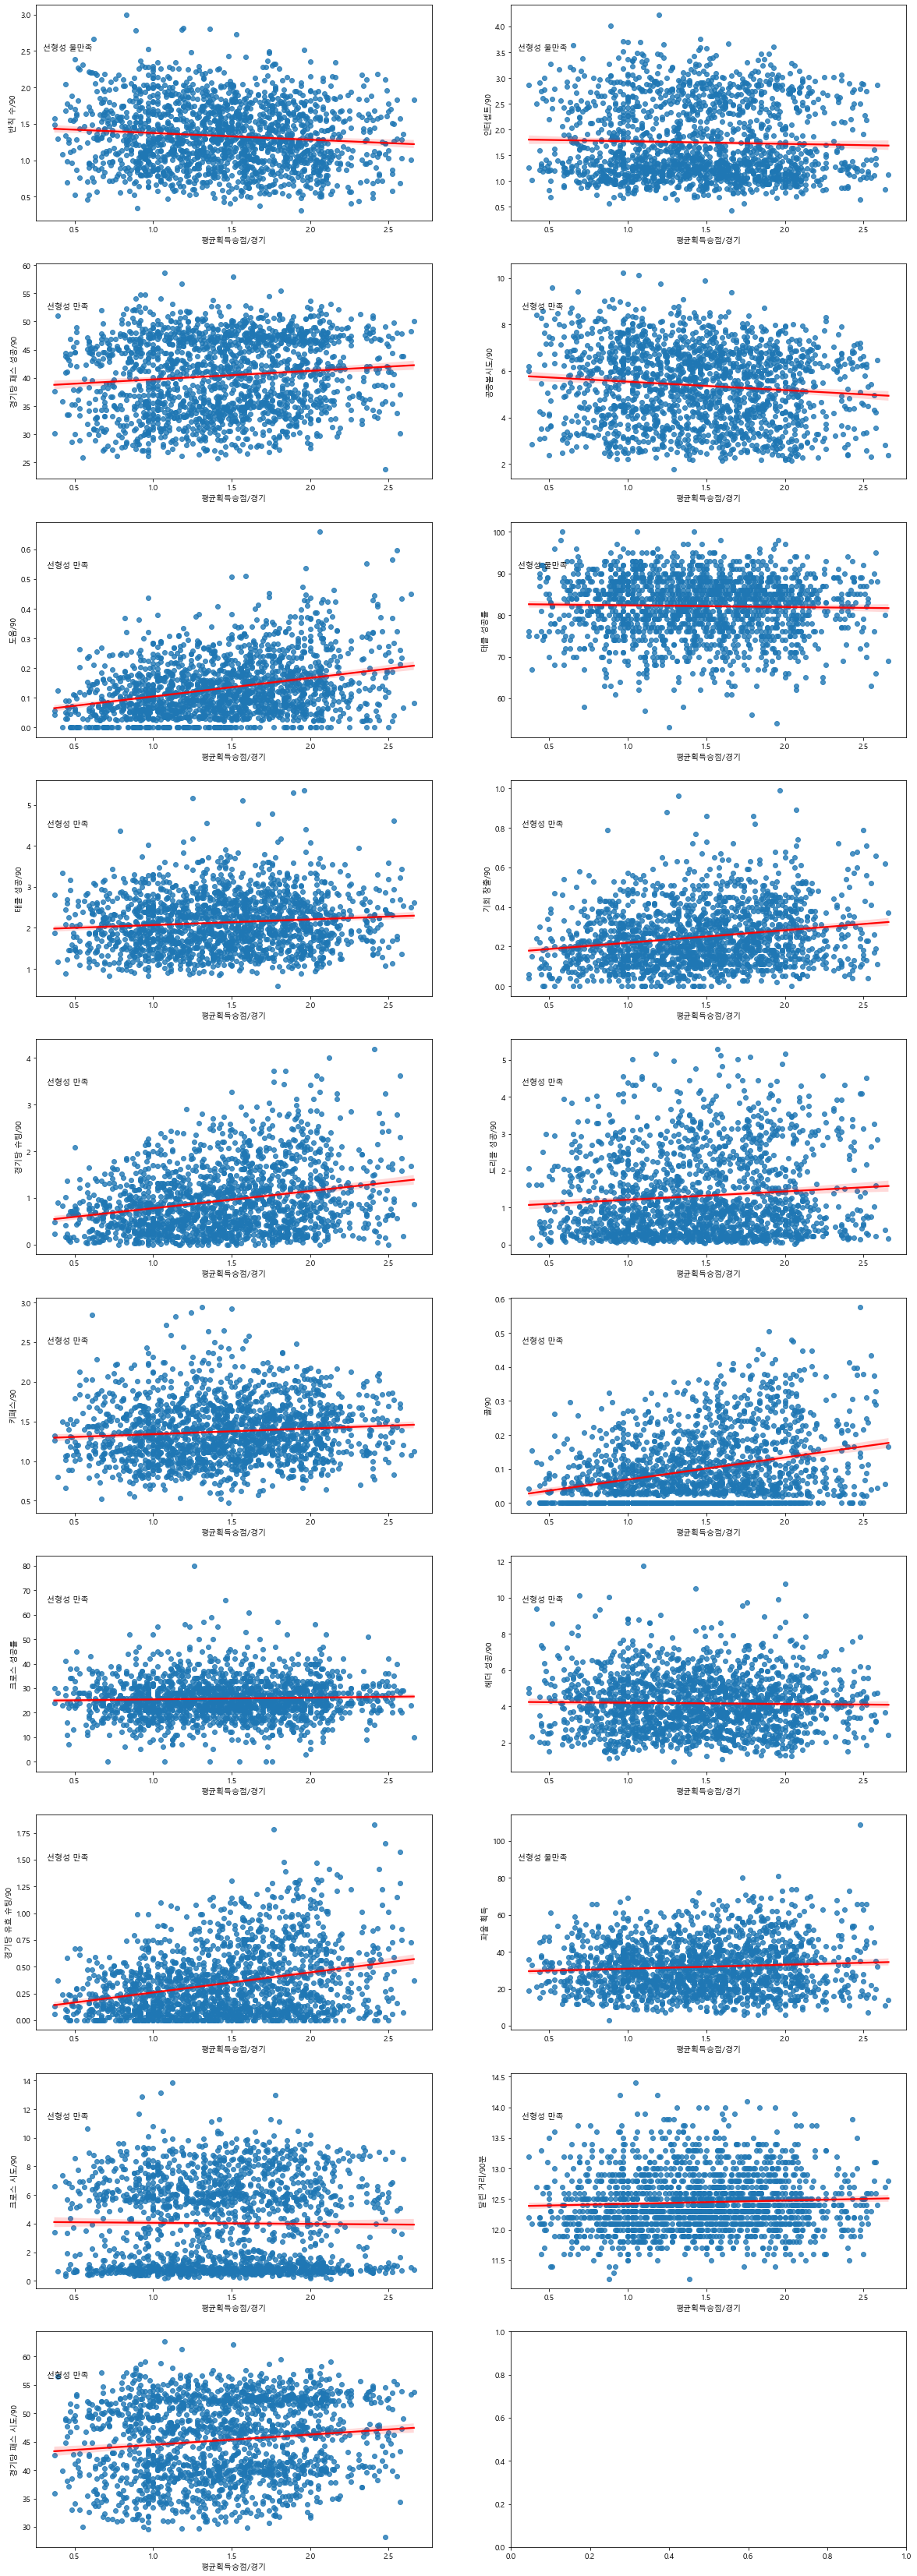

In [6]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=midfielder_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(midfielder_df[dependent_value],midfielder_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

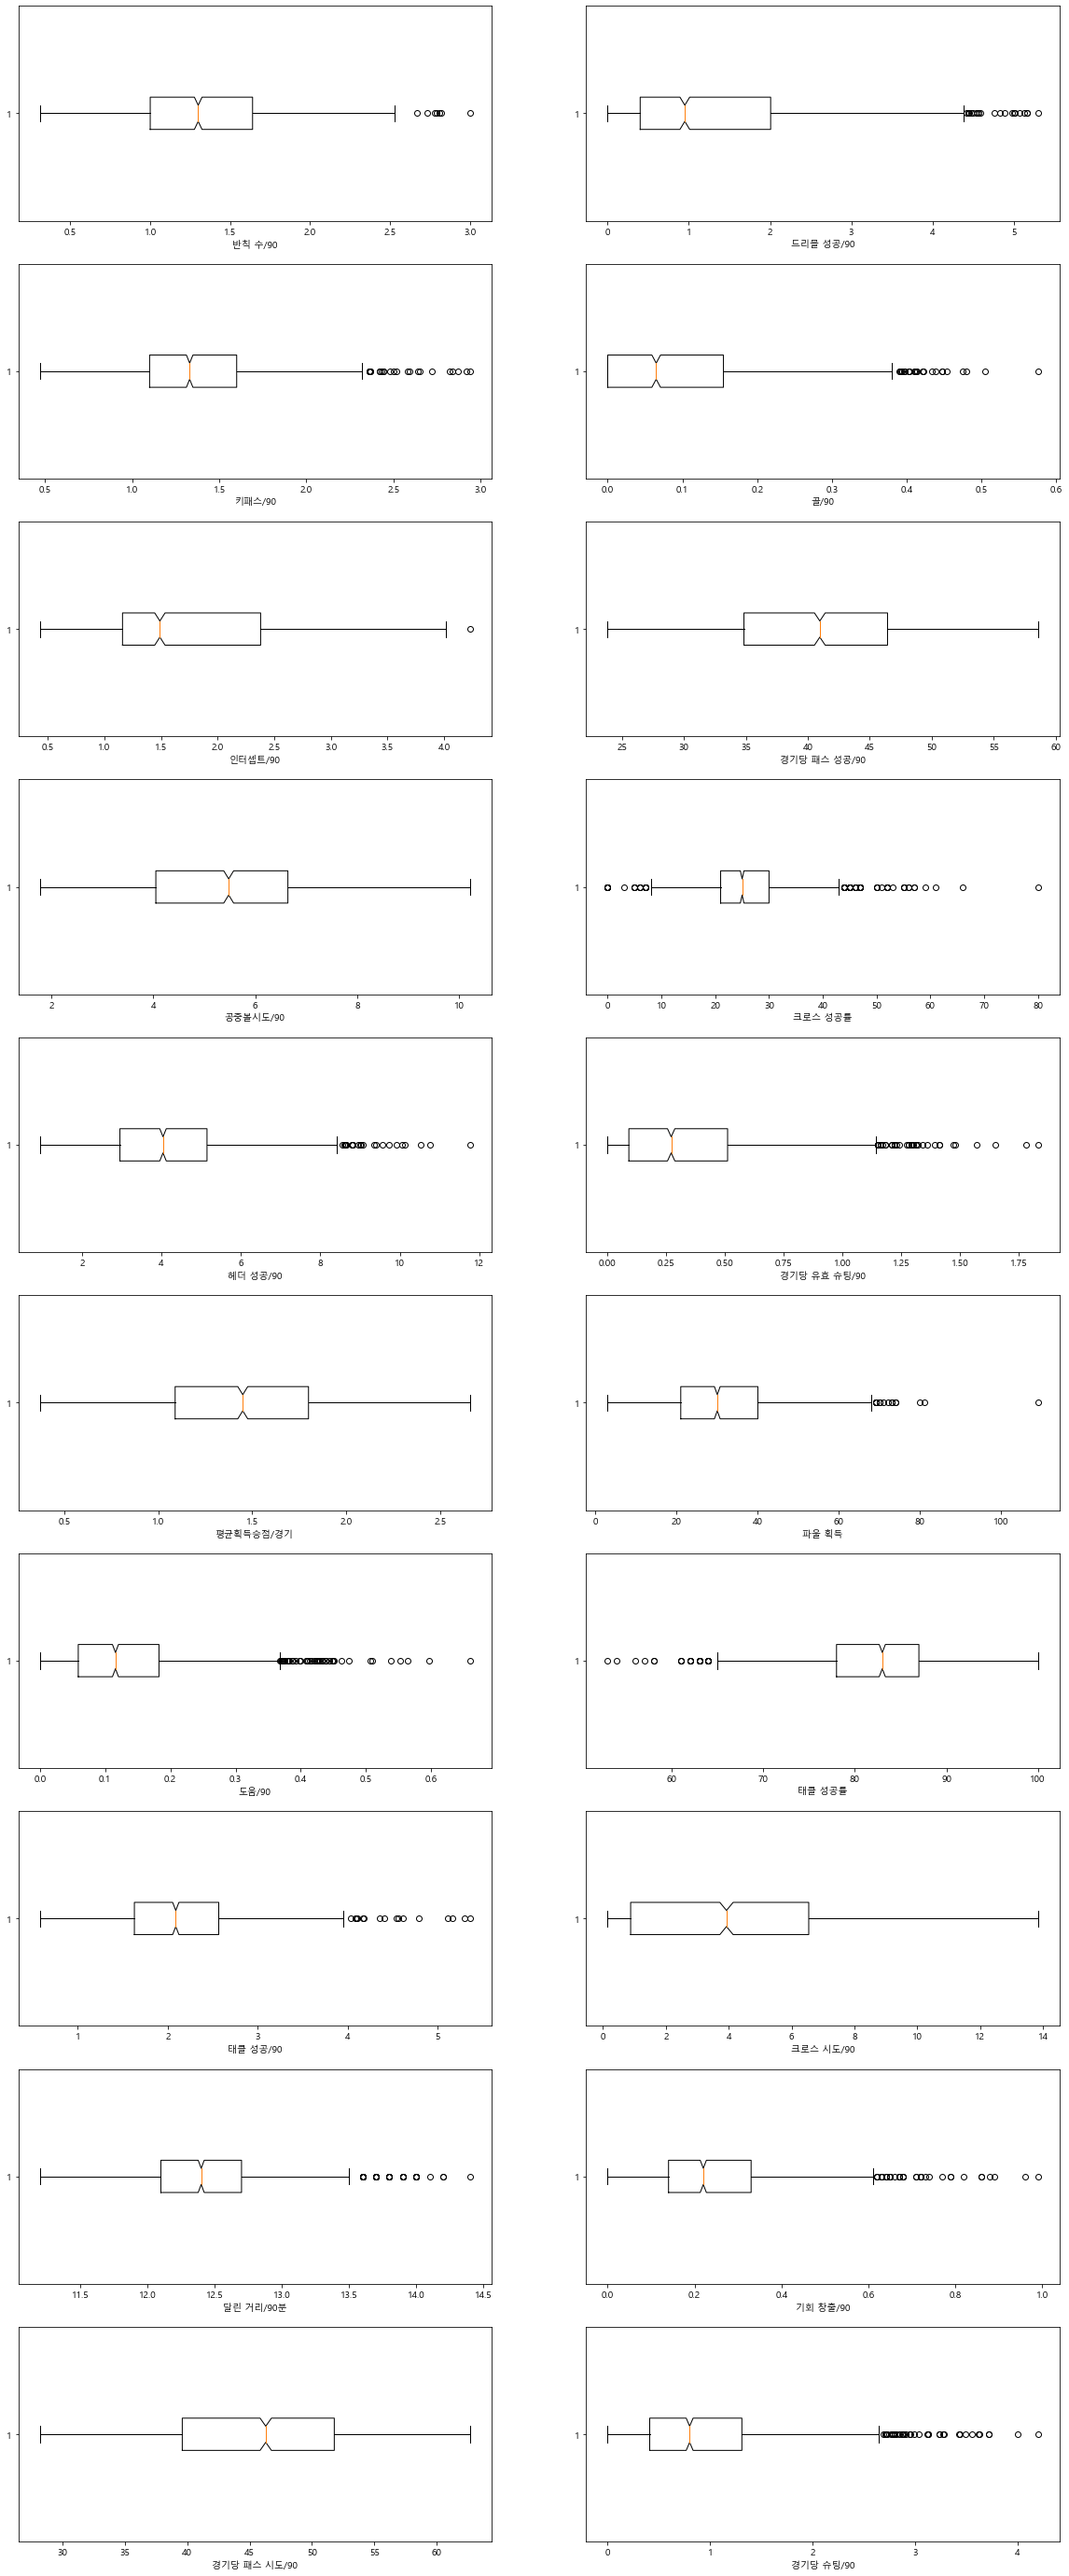

In [7]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value | set([dependent_value]))) :
    ax.set_xlabel(feature)
    ax.boxplot(midfielder_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [8]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = midfielder_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/len(midfielder_df)*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(midfielder_df)}개의 데이터 중 {len(total)} 개 입니다.')

반칙 수/90중 이상치는 13개 비율은 약 0.733% 입니다

인터셉트/90중 이상치는 7개 비율은 약 0.395% 입니다

경기당 패스 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

공중볼시도/90중 이상치는 2개 비율은 약 0.113% 입니다

도움/90중 이상치는 73개 비율은 약 4.115% 입니다

태클 성공률중 이상치는 36개 비율은 약 2.029% 입니다

태클 성공/90중 이상치는 28개 비율은 약 1.578% 입니다

기회 창출/90중 이상치는 57개 비율은 약 3.213% 입니다

경기당 슈팅/90중 이상치는 81개 비율은 약 4.566% 입니다

드리블 성공/90중 이상치는 71개 비율은 약 4.002% 입니다

키패스/90중 이상치는 42개 비율은 약 2.368% 입니다

골/90중 이상치는 74개 비율은 약 4.171% 입니다

크로스 성공률중 이상치는 87개 비율은 약 4.904% 입니다

헤더 성공/90중 이상치는 35개 비율은 약 1.973% 입니다

경기당 유효 슈팅/90중 이상치는 78개 비율은 약 4.397% 입니다

파울 획득중 이상치는 38개 비율은 약 2.142% 입니다

크로스 시도/90중 이상치는 0개 비율은 약 0.0% 입니다

달린 거리/90분중 이상치는 92개 비율은 약 5.186% 입니다

경기당 패스 시도/90중 이상치는 0개 비율은 약 0.0% 입니다

이상치가 있는 row의 갯수는 총 1774개의 데이터 중 561 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

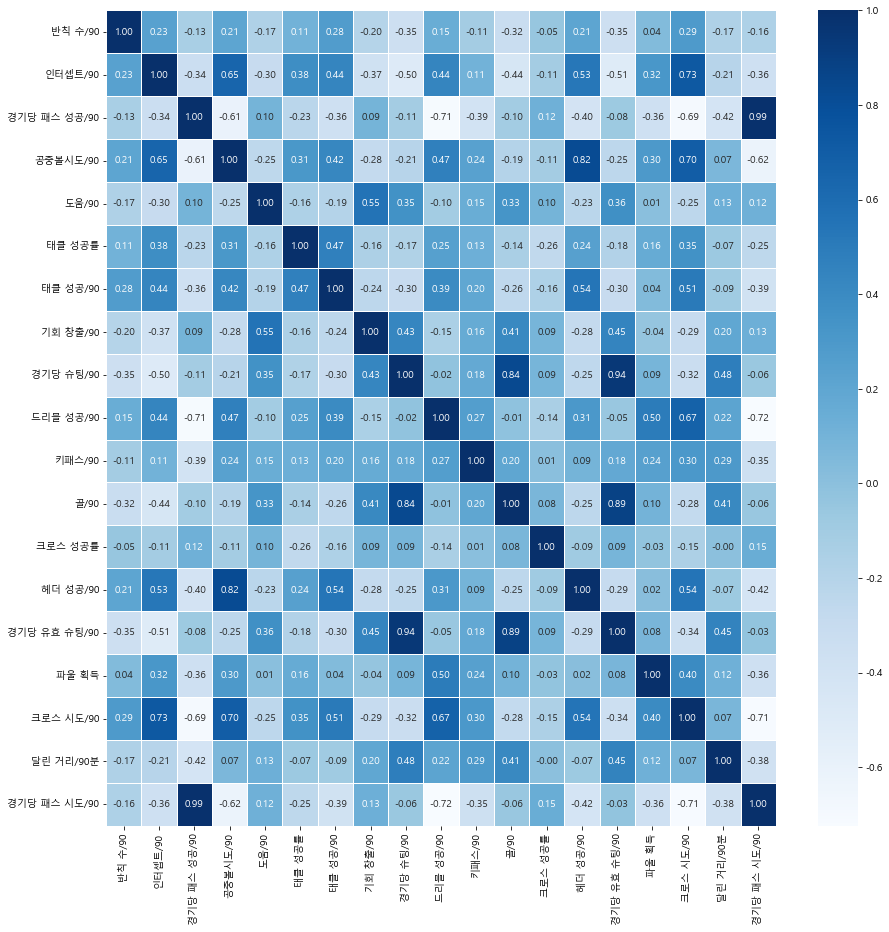

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data = midfielder_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues');

#### 독립변수 간 상관계수가 0.9이상인 변수들

In [10]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(midfielder_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 패스 성공/90,경기당 패스 시도/90,0.989598
1,경기당 슈팅/90,경기당 유효 슈팅/90,0.941160


## 상관계수, 다중 공선성

In [11]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(midfielder_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,도움/90,평균획득승점/경기,0.271288
1,골/90,평균획득승점/경기,0.261115
2,경기당 유효 슈팅/90,평균획득승점/경기,0.239562
3,경기당 슈팅/90,평균획득승점/경기,0.215082
4,기회 창출/90,평균획득승점/경기,0.184712
5,경기당 패스 시도/90,평균획득승점/경기,0.122997
6,키패스/90,평균획득승점/경기,0.112931
7,경기당 패스 성공/90,평균획득승점/경기,0.109960
8,공중볼시도/90,평균획득승점/경기,-0.098937
9,반칙 수/90,평균획득승점/경기,-0.089919


In [12]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,4.353990,도움/90
1,6.254298,기회 창출/90
2,6.609481,드리블 성공/90
3,9.073632,골/90
4,11.216085,파울 획득
5,12.240260,크로스 성공률
6,12.517782,반칙 수/90
7,13.265795,크로스 시도/90
8,22.104620,키패스/90
9,23.200689,인터셉트/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [13]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [14]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(midfielder_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [15]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(midfielder_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수'])
    return df

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골/90,경기당 슈팅, 유효 슈팅
2. 도움/90, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골/90과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [16]:
midfielder_df[['골/90','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골/90,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골/90,1.000000,0.885045,0.837267,0.299319
경기당 유효 슈팅/90,0.885045,1.000000,0.944419,0.285341
경기당 슈팅/90,0.837267,0.944419,1.000000,0.248302
평균획득승점/경기,0.299319,0.285341,0.248302,1.000000


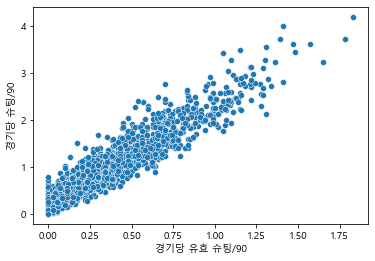

In [17]:
sns.scatterplot(x='경기당 유효 슈팅/90',y='경기당 슈팅/90',data=midfielder_df);

#### 피쳐 엔지니어링

In [18]:
# Goal_Shoot_linear
midfielder_df['GSL'] = (midfielder_df['경기당 유효 슈팅/90']+0.5) + (midfielder_df['경기당 슈팅/90']) + (midfielder_df['골/90']*1.3)

independent_value.add('GSL')
independent_value = independent_value - set(['골/90','경기당 슈팅/90','경기당 유효 슈팅/90'])

midfielder_df[['이름','GSL']].sort_values(by='GSL',ascending=False).head()

,이름,GSL
341,Lionel Messi,7.068285
1216,Amine Gouiri,6.525449
935,Lionel Messi,6.419878
933,Neymar,6.214438
1519,Neymar,6.187094


#### 상관계수 확인 (통과)

In [19]:
midfielder_df[['GSL','평균획득승점/경기']].corr()

,GSL,평균획득승점/경기
GSL,1.000000,0.270976
평균획득승점/경기,0.270976,1.000000


In [20]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.352709,도움/90
1,6.248073,기회 창출/90
2,6.595403,드리블 성공/90
3,8.984910,GSL
4,11.211171,파울 획득
5,12.240155,크로스 성공률
6,12.503553,반칙 수/90
7,13.258742,크로스 시도/90
8,22.043632,키패스/90
9,23.190542,인터셉트/90


In [21]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,경기당 패스 성공/90,경기당 패스 시도/90,0.989598


### 경기당 패스 성공/90 경기당 패스 시도/90

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [22]:
midfielder_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.991940,0.106443
경기당 패스 시도/90,0.991940,1.000000,0.121597
평균획득승점/경기,0.106443,0.121597,1.000000


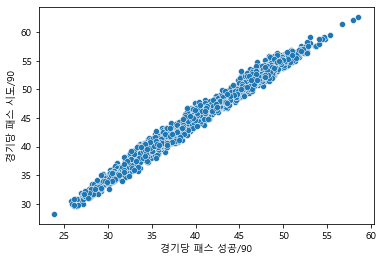

In [23]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=midfielder_df);

#### 피쳐 엔지니어링

In [24]:
# PSTL = Pass sucess try linear

midfielder_df['PSTL'] = (midfielder_df['경기당 패스 성공/90']) + (midfielder_df['경기당 패스 시도/90'])*1.15

independent_value.add('PSTL')
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

midfielder_df[['이름','PSTL']].sort_values(by='PSTL',ascending=False).head()

,이름,PSTL
579,Ivan Ilić,130.6420
491,Danilo Cataldi,129.3520
1097,Davide Frattesi,127.2440
727,Frenkie de Jong,123.7935
961,Kalvin Phillips,122.7110


#### 상관계수 확인 (통과)

In [25]:
midfielder_df[['PSTL','평균획득승점/경기']].corr()

,PSTL,평균획득승점/경기
PSTL,1.000000,0.114923
평균획득승점/경기,0.114923,1.000000


In [26]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.350375,도움/90
1,6.224041,기회 창출/90
2,6.519803,드리블 성공/90
3,8.845717,GSL
4,11.211108,파울 획득
5,12.045331,크로스 성공률
6,12.453010,반칙 수/90
7,13.229455,크로스 시도/90
8,20.501023,키패스/90
9,23.119253,인터셉트/90


### 피쳐 삭제

In [27]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움/90',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [28]:
independent_value = independent_value - set(['달린 거리/90분','태클 성공률','헤더 성공/90','크로스 시도/90','인터셉트/90','파울 획득','크로스 성공률'])

In [29]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
0,도움/90,평균획득승점/경기,0.271288
1,GSL,평균획득승점/경기,0.232070
2,기회 창출/90,평균획득승점/경기,0.184712
3,PSTL,평균획득승점/경기,0.117833
4,키패스/90,평균획득승점/경기,0.112931
5,공중볼시도/90,평균획득승점/경기,-0.098937
6,반칙 수/90,평균획득승점/경기,-0.089919
7,태클 성공/90,평균획득승점/경기,0.089120
8,드리블 성공/90,평균획득승점/경기,0.078994


In [30]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.143310,드리블 성공/90
1,4.314102,도움/90
2,5.441111,GSL
3,6.169373,기회 창출/90
4,11.436040,반칙 수/90
5,15.731512,태클 성공/90
6,16.104816,공중볼시도/90
7,17.135934,키패스/90
8,19.029555,PSTL


In [31]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [32]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 최종 종속변수

In [33]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [34]:
midfielder_df.columns

Index(['이름', '포지션', '리그', '골/90', '도움/90', '경기당 팀 득점/90', '경기당 팀 실점/90',
       '크로스 성공률', '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90',
       '인터셉트/90', '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90',
       '경기당 패스 성공/90', '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90',
       '크로스 시도/90', '평균획득승점/경기', '승', '무', '패', '시즌', '구단', 'GSL', 'PSTL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

In [35]:
x_train,x_test,y_train,y_test = train_test_split(midfielder_df.loc[:,independent_value],midfielder_df.loc[:,dependent_value])

midfielder_x_po = RobustScaler().fit(x_train.loc[:,independent_value])

x_train.loc[:,independent_value] = midfielder_x_po.transform(x_train.loc[:,independent_value])
x_test.loc[:,independent_value] = midfielder_x_po.transform(x_test.loc[:,independent_value])

# 모델 생성

In [36]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(10,activation='relu')(inputs_layer)
hidden2 = Dense(20,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(40,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
hidden4 = Dense(20,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(10,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden4)
output = Dense(1,activation='linear')(hidden5)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(x_train.loc[:,independent_value],y_train,batch_size=150,epochs=1000,validation_data=(x_test.loc[:,independent_value],y_test))  
predict_result=model.predict(x_test.loc[:,independent_value])
mae = mean_absolute_error(y_test,predict_result)

Epoch 1/1000
9/9 [==============================] - 0s 15ms/step - loss: 2.4226 - val_loss: 2.0206
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.8085 - val_loss: 1.4613
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.3552 - val_loss: 1.1832
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.1942 - val_loss: 1.0952
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0844 - val_loss: 0.9838
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.9899 - val_loss: 0.9199
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.9224 - val_loss: 0.8673
Epoch 8/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.8697 - val_loss: 0.8263
Epoch 9/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.8271 - val_loss: 0.7904
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.7902 - val_loss: 0.7591
Epoch 11/1000
9/9 

Epoch 84/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2305 - val_loss: 0.2296
Epoch 85/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2293 - val_loss: 0.2286
Epoch 86/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2283 - val_loss: 0.2276
Epoch 87/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2269 - val_loss: 0.2258
Epoch 88/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2256 - val_loss: 0.2254
Epoch 89/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2246 - val_loss: 0.2235
Epoch 90/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2232 - val_loss: 0.2222
Epoch 91/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2222 - val_loss: 0.2213
Epoch 92/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2212 - val_loss: 0.2208
Epoch 93/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2197 - val_loss: 0.2191
Epoch 94/1

9/9 [==============================] - 0s 2ms/step - loss: 0.1832 - val_loss: 0.1856
Epoch 167/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1829 - val_loss: 0.1843
Epoch 168/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1827 - val_loss: 0.1846
Epoch 169/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1824 - val_loss: 0.1846
Epoch 170/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1828 - val_loss: 0.1844
Epoch 171/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1836 - val_loss: 0.1839
Epoch 172/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1820 - val_loss: 0.1838
Epoch 173/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1818 - val_loss: 0.1845
Epoch 174/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1815 - val_loss: 0.1833
Epoch 175/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1813 - val_loss: 0.1838
Epoch 176/1000


9/9 [==============================] - 0s 2ms/step - loss: 0.1740 - val_loss: 0.1777
Epoch 249/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1735 - val_loss: 0.1778
Epoch 250/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1738 - val_loss: 0.1777
Epoch 251/1000
9/9 [==============================] - 0s 1ms/step - loss: 0.1735 - val_loss: 0.1782
Epoch 252/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1733 - val_loss: 0.1779
Epoch 253/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1734 - val_loss: 0.1773
Epoch 254/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1732 - val_loss: 0.1786
Epoch 255/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.1775
Epoch 256/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1729 - val_loss: 0.1797
Epoch 257/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1731 - val_loss: 0.1772
Epoch 258/1000


9/9 [==============================] - 0s 2ms/step - loss: 0.1699 - val_loss: 0.1768
Epoch 331/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1699 - val_loss: 0.1758
Epoch 332/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1697 - val_loss: 0.1759
Epoch 333/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1696 - val_loss: 0.1758
Epoch 334/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1696 - val_loss: 0.1761
Epoch 335/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1699 - val_loss: 0.1759
Epoch 336/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1697 - val_loss: 0.1767
Epoch 337/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1698 - val_loss: 0.1752
Epoch 338/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1699 - val_loss: 0.1762
Epoch 339/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1694 - val_loss: 0.1754
Epoch 340/1000


9/9 [==============================] - 0s 2ms/step - loss: 0.1682 - val_loss: 0.1744
Epoch 413/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1689 - val_loss: 0.1742
Epoch 414/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1695 - val_loss: 0.1739
Epoch 415/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1681 - val_loss: 0.1752
Epoch 416/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1677 - val_loss: 0.1743
Epoch 417/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1684 - val_loss: 0.1749
Epoch 418/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1682 - val_loss: 0.1741
Epoch 419/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1687 - val_loss: 0.1753
Epoch 420/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1681 - val_loss: 0.1741
Epoch 421/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1671 - val_loss: 0.1744
Epoch 422/1000


Epoch 494/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1670 - val_loss: 0.1730
Epoch 495/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1674 - val_loss: 0.1746
Epoch 496/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.1730
Epoch 497/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.1731
Epoch 498/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1655 - val_loss: 0.1739
Epoch 499/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.1737
Epoch 500/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1667 - val_loss: 0.1733
Epoch 501/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1664 - val_loss: 0.1735
Epoch 502/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1656 - val_loss: 0.1728
Epoch 503/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1656 - val_loss: 0.1739


Epoch 576/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1646 - val_loss: 0.1725
Epoch 577/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1642 - val_loss: 0.1731
Epoch 578/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1641 - val_loss: 0.1729
Epoch 579/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1641 - val_loss: 0.1728
Epoch 580/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1639 - val_loss: 0.1726
Epoch 581/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1641 - val_loss: 0.1740
Epoch 582/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1640 - val_loss: 0.1723
Epoch 583/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1642 - val_loss: 0.1732
Epoch 584/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1643 - val_loss: 0.1727
Epoch 585/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1642 - val_loss: 0.1732


Epoch 658/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1639 - val_loss: 0.1743
Epoch 659/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1627 - val_loss: 0.1728
Epoch 660/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1626 - val_loss: 0.1733
Epoch 661/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1629 - val_loss: 0.1729
Epoch 662/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1626 - val_loss: 0.1736
Epoch 663/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1627 - val_loss: 0.1732
Epoch 664/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1625 - val_loss: 0.1734
Epoch 665/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1627 - val_loss: 0.1734
Epoch 666/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1629 - val_loss: 0.1729
Epoch 667/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1629 - val_loss: 0.1740


Epoch 740/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1614 - val_loss: 0.1732
Epoch 741/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1617 - val_loss: 0.1723
Epoch 742/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1615 - val_loss: 0.1725
Epoch 743/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1615 - val_loss: 0.1729
Epoch 744/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1614 - val_loss: 0.1729
Epoch 745/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1614 - val_loss: 0.1727
Epoch 746/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1616 - val_loss: 0.1727
Epoch 747/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1617 - val_loss: 0.1729
Epoch 748/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1620 - val_loss: 0.1725
Epoch 749/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1624 - val_loss: 0.1724


Epoch 822/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1608 - val_loss: 0.1720
Epoch 823/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1606 - val_loss: 0.1728
Epoch 824/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1604 - val_loss: 0.1717
Epoch 825/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1721
Epoch 826/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1614 - val_loss: 0.1722
Epoch 827/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1610 - val_loss: 0.1721
Epoch 828/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1606 - val_loss: 0.1724
Epoch 829/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1603 - val_loss: 0.1722
Epoch 830/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1604 - val_loss: 0.1719
Epoch 831/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1605 - val_loss: 0.1723


Epoch 904/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1594 - val_loss: 0.1721
Epoch 905/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1593 - val_loss: 0.1714
Epoch 906/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1597 - val_loss: 0.1727
Epoch 907/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1598 - val_loss: 0.1714
Epoch 908/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1596 - val_loss: 0.1720
Epoch 909/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1594 - val_loss: 0.1719
Epoch 910/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1593 - val_loss: 0.1715
Epoch 911/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1597 - val_loss: 0.1721
Epoch 912/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1597 - val_loss: 0.1718
Epoch 913/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1595 - val_loss: 0.1722


Epoch 986/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1591 - val_loss: 0.1712
Epoch 987/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1591 - val_loss: 0.1720
Epoch 988/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1587 - val_loss: 0.1710
Epoch 989/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1586 - val_loss: 0.1715
Epoch 990/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1587 - val_loss: 0.1716
Epoch 991/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1586 - val_loss: 0.1718
Epoch 992/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1592 - val_loss: 0.1714
Epoch 993/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1587 - val_loss: 0.1713
Epoch 994/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1586 - val_loss: 0.1715
Epoch 995/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1590 - val_loss: 0.1710


In [37]:
mae

0.3188983310235513

In [38]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [39]:
midfielder_df.loc[:,independent_value] = midfielder_x_po.transform(midfielder_df.loc[:,independent_value])

In [40]:
y_pred = model.predict(midfielder_df.loc[:,independent_value])

In [41]:
midfielder_df['예측_PPG'] = y_pred

In [42]:
midfielder_df.sort_values(by='예측_PPG').head()

,이름,포지션,리그,골/90,도움/90,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,...,크로스 시도/90,평균획득승점/경기,승,무,패,시즌,구단,GSL,PSTL,예측_PPG
460,Nathaniel Clyne,미드필더,잉글랜드 프리미어 리그,0.000000,-0.171814,1.36,1.33,19.0,26,0.365079,...,5.63,1.31,13.0,8.0,15.0,2021-2022,팰리스,-0.596557,-0.785935,1.025838
1163,Junior Sornoza,미드필더,이탈리아 세리에 A,0.000000,0.110248,0.90,1.54,31.0,15,-0.428571,...,2.24,0.95,4.0,7.0,9.0,2022-2023,토리노,-0.227181,-0.480621,1.025838
1408,Stefan Lainer,미드필더,스페인 프리메라 디비전,0.024318,-0.331350,1.31,1.48,25.0,42,1.158730,...,6.42,1.20,13.0,10.0,18.0,2023-2024,우에스카,-0.387280,-0.743649,1.025839
843,Saïf-Eddine Khaoui,미드필더,프랑스 리그 1,0.158870,-0.598306,1.23,1.47,27.0,22,-0.857143,...,5.20,1.10,9.0,5.0,15.0,2022-2023,님,0.609981,-0.663030,1.025839
1300,Martín Montoya,미드필더,스페인 프리메라 디비전,0.028599,-0.457905,1.20,1.63,21.0,30,1.000000,...,6.63,1.03,10.0,7.0,19.0,2023-2024,그라나다,-0.128337,-0.542376,1.025839


# 모델검정

In [43]:
residual = midfielder_df['평균획득승점/경기'] - midfielder_df['예측_PPG']

## 잔차의 정규성 검정

In [44]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9985931515693665, pvalue=0.15383952856063843)

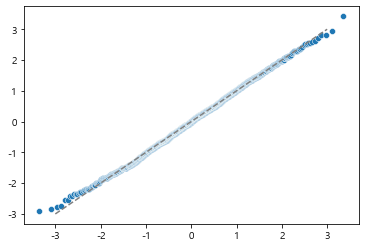

In [45]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey');

## 잔차의 등분산성 검정

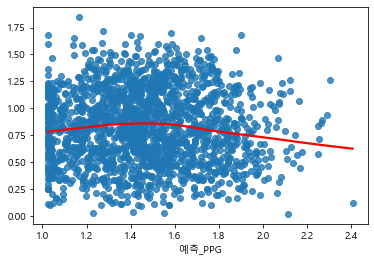

In [46]:
sns.regplot(midfielder_df['예측_PPG'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'});

In [47]:
# 등분산성 불만족
stats.levene(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG'])

LeveneResult(statistic=541.6898047931232, pvalue=1.2632911394778386e-111)

In [48]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

0.9090383008668088

In [49]:
mean_absolute_error(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG'])

0.30951937541348823

In [50]:
np.sqrt(mean_squared_error(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG']))

0.38395184445190667

In [51]:
with open('./models/midfielder/midfielder_po.pickle','wb') as f:
     pickle.dump(midfielder_x_po,f)

In [52]:
model.save('./models/midfielder/midfielder_nn.h5')